<a href="https://colab.research.google.com/github/finlaycm/tensorflow_tumor_detection/blob/master/all_slides_evaluation_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Extracting patches with tissues from new slide
###Author: Cristina Martinez Finlay
###UNI: cm2592

##Initial Code

In [ ]:
##Initial variables
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from google.colab import drive
import os
colab_root_dir = '/content'
drive_dir='/content/drive'
project_root_dir = os.path.join(drive_dir,'My Drive','deeplearning','cancer_classification')
eval_dir = os.path.join(project_root_dir,'eval')
patch_folder = os.path.join(colab_root_dir,'patches')
os.makedirs(patch_folder, exist_ok = True)
drive.mount(drive_dir)


#Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

##Import modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import cv2 as cv
import json
from google.colab import drive
import pathlib
import shutil
import random
import time 
import pandas as pd
import sklearn

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Flatten, Input, MaxPooling2D, Conv2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

from sklearn import metrics

import xml.etree.ElementTree as et 


test_slides = ['tumor_094','tumor_019','tumor_016','tumor_031']

slide_dir=os.path.join(project_root_dir,'myslides')
slide_files = [os.path.join(slide_dir,s) for s in os.listdir(slide_dir)if pathlib.Path(s).stem in test_slides ]
mask_dir=os.path.join(project_root_dir,'mymasks')
mask_files = [os.path.join(mask_dir,m) for m in os.listdir(mask_dir) if pathlib.Path(m).stem.replace('_mask','') in test_slides ]
xml_dir=os.path.join(project_root_dir,'myannotations')
xml_files = [os.path.join(xml_dir,x) for x in os.listdir(xml_dir) if pathlib.Path(x).stem in test_slides ]



TensorFlow 2.x selected.
2.1.0-rc1
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 n

## Prepare new slide for evaluation. Code





In [ ]:
def read_mask(mask, level, x , y , width, height):
    msk = mask.read_region((x,y), level, (width, height))
    msk = msk.convert('RGB') # drop the alpha channel
    msk = np.asarray(msk)
    msk = msk[:,:,0]
    return msk
def read_slide(slide, level, x , y , width, height):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    im = np.asarray(im)
    return im

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, thr = sklearn.metrics.roc_curve(labels, predictions)
  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')
  ax.set_title('ROC Curve')
  return fp, tp, thr
def read_patches_from_region(slide, slide_name, x_orig, y_orig , pwidth, pheight ,level):
  ##starting at level 7, extract 256X256 images and determine if it
  ##has tissues or not. record coordinates of regions with tissues to break down in next interation
  #at the  next zoom level into 4 256X256 regions. Disgregard regions with no tissues. 
  #When level 0 is reached save coorninates of patch in patch_locators numpy array in 
  global p, patch_locators
  width, height = slide.level_dimensions[level]
  thr=10/(2**level)
  for x in range(x_orig,x_orig+pwidth,256):
    for y in range(y_orig,y_orig+pheight,256):
      w = min(width - x, 256)
      h = min(height - y, 256)
      im = slide.read_region((x*2**level,y*2**level), level, (w, h))
      im = im.convert('RGB')
      im = np.asarray(im)
      contains_tissues = low_tissue_area(im, intensity=0.8, threshold=thr)
      if contains_tissues == 1:
        regions[level].append((x,y,w,h))
        if level == 0: 
          if p ==0:print('\nPatches location extracted so far :',end='')
          if (p + 1) % 1000 == 0:print(p,end=',')
          if (p + 1) % 10000 == 0:print('\n',end='')
          patch_locators.append((x,y,w,h))
          p +=1
  return regions, patch_locators

def low_tissue_area(image, intensity=0.8, threshold=0.1):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    tissue_pixels = list(zip(indices[0], indices[1]))
    percent_tissue = len(tissue_pixels) * 100/ float(image.shape[0] * image.shape[1]) 
    if percent_tissue >= threshold:
      return 1
    else: 
      return 0
def extract_tissue_patches(slide_name):
  global regions
  img = read_slide(slide,7, show = True)
  levels = [i for i in range(6,-1,-1)]
  ## FIRST RUN at level 7
  level = 7
  width, height = slide.level_dimensions[level]
  regions, patch_locators = read_patches_from_region(slide, slide_name, slide_patch_folder, 0, 0 , width, height ,level)
  start_time = time.time()
  now = time.strftime("%H:%M", time.localtime(start_time))
  print("Start Time {} ".format(now)) 
  for level in levels:
    print('Level {} , Previous level total regions: {}'.format(level, len(regions[level+1])))
    for r in regions[level+1]:
      x_orig, y_orig , pwidth, pheight = r
      reg, path_locators_level0 = read_patches_from_region(slide, slide_name\
                    , slide_patch_folder, x_orig*2, y_orig*2 , pwidth*2, pheight*2 ,level)
  end_time = time.time()
  now = time.strftime("%H:%M", time.localtime(end_time))
  print("End Time {} ".format(now)) 
  print("--- %s seconds ---" % (end_time - start_time))
  return path_locators_level0

def show_patches_location_next_to_image(slide_name):
  level = 7
  slide_path = os.path.join(slide_dir,slide_name+'.tif')
  slide = open_slide(slide_path)
  width = slide.level_dimensions[level][0]
  height = slide.level_dimensions[level][1]
  dim = (height,width)
  pat = np.zeros(dim)
  patch_locator_filename = slide_name+'_patchlocators.npy'
  path_locators_level = np.load(patch_locator_filename,allow_pickle = True)
  total_patches_extracted = len(path_locators_level)
  pos_idx = [i for i in range(total_patches_extracted)]
  for i in pos_idx:
    x,y,w,h = np.array(path_locators_level[i])//2**level
    pat[y:y+h,x:x+w] = 1
  img = read_slide(slide,7,0,0,width,height)
  fig, axs = plt.subplots(ncols=2,nrows=1, figsize=(15,5))

  axs[0].imshow(img)
  axs[1].imshow(pat)
  axs[0].axis('off')
  axs[1].axis('off')

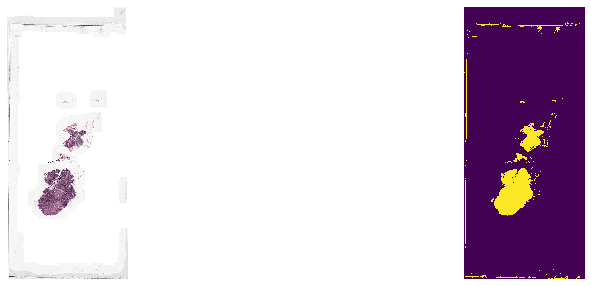

In [ ]:
for slide_name in test_slides:
  show_patches_location_next_to_image(slide_name)

In [ ]:
####Get coordinates of patches with tissues
for slide_name in test_slides[3:]:
  p = 0
  patch_locators = []
  regions = {i:[] for i in range(8)}
  levels = [i for i in range(6,-1,-1)]
  print(slide_name)
  print('Recording patches locators for slide {}'.format (slide_name)) 
  slide_path = [s for s in slide_files if slide_name in s][0]
  slide = open_slide(slide_path)
  ## FIRST RUN at level 7
  level = 7
  width, height = slide.level_dimensions[level]
  regions, patch_locators = read_patches_from_region(slide, slide_name, 0, 0 , width, height ,level)
  start_time = time.time()
  now = time.strftime("%H:%M", time.localtime(start_time))
  print("Start Time {} ".format(now)) 
  for level in levels:
    print('Level {} , Previous level total regions: {}'.format(level, len(regions[level+1])))
    for r in regions[level+1]:
      x_orig, y_orig , pwidth, pheight = r
      reg, path_locators_level0 = read_patches_from_region(slide, slide_name,\
                                  x_orig*2, y_orig*2 , pwidth*2, pheight*2 ,level)
  end_time = time.time()
  now = time.strftime("%H:%M", time.localtime(end_time))
  print("\nEnd Time {} ".format(now)) 
  print("--- %s seconds ---" % (end_time - start_time))
  patch_locators_name = slide_name+'_patchlocators'
  np.save(patch_locators_name, path_locators_level0)
  shutil.copy(patch_locators_name+'.npy', os.path.join(eval_dir,slide_name))


tumor_031
Recording patches locators for slide tumor_031
Start Time 19:10 
Level 6 , Previous level total regions: 19
Level 5 , Previous level total regions: 36
Level 4 , Previous level total regions: 76
Level 3 , Previous level total regions: 194
Level 2 , Previous level total regions: 549
Level 1 , Previous level total regions: 1577
Level 0 , Previous level total regions: 4655

Patches location extracted so far :999,1999,2999,3999,4999,5999,6999,7999,8999,9999,
10999,11999,12999,13999,14999,
End Time 19:42 
--- 1900.7151296138763 seconds ---


In [ ]:
shutil.rmtree('patches')
_=[os.makedirs(os.path.join('patches',l),exist_ok=True) for l in ['positive','negative']]

_=[shutil.copy(str(f),colab_root_dir) for f in pathlib.Path(eval_dir).glob('*/*') \
   if f.stem.replace('_patchlocators','') in test_slides]

In [ ]:
### Extract patch images and save in class directory
for slide_name in test_slides:
  patches_folder_name = slide_name+'_patches'
  _=[os.makedirs(os.path.join(patches_folder_name,l),exist_ok=True) for l in ['positive','negative']]
  loc = np.load(slide_name+'_patchlocators.npy',allow_pickle = True)
  print('Extracting {} tissue patches for slide {}'.format (loc.shape[0], slide_name)) 
  slide_path = [s for s in slide_files if slide_name in s][0]
  mask_path = [m for m in mask_files if slide_name in m][0]
  slide = open_slide(slide_path)
  mask = open_slide(mask_path)
  for i,p in enumerate(loc):
    x,y,w,h = p
    truth = 'positive' if read_mask(mask,0, x,y,w,h).sum() > 0 else 'negative'
    patch = read_slide(slide,0, x,y,w,h)
    patch_path = os.path.join(patches_folder_name,truth,'patch-{}-{}-{}.jpg'.format(slide_name,x,y))
    Image.fromarray(patch).save(patch_path)
    if (i + 1) % 1000 == 0:print(i,end=',')
    if (i + 1) % 10000 == 0:print('\n',end='')
  print('\n')
  shutil.make_archive(patches_folder_name, 'zip', 'patches')
  shutil.copy(patches_folder_name+'.zip',os.path.join(eval_dir,slide_name))


Extracting 54940 tissue patches for slide tumor_094
999,1999,2999,3999,4999,5999,6999,7999,8999,9999,
10999,11999,12999,13999,14999,15999,16999,17999,18999,19999,
20999,21999,22999,23999,24999,25999,26999,27999,28999,29999,
30999,31999,32999,33999,34999,35999,36999,37999,38999,39999,
40999,41999,42999,43999,44999,45999,46999,47999,48999,49999,
50999,51999,52999,53999,

Extracting 14229 tissue patches for slide tumor_019
999,1999,2999,3999,4999,5999,6999,7999,8999,9999,
10999,11999,12999,13999,

Extracting 21593 tissue patches for slide tumor_016
999,1999,2999,3999,4999,5999,6999,7999,8999,9999,
10999,11999,12999,13999,14999,15999,16999,17999,18999,19999,
20999,



In [ ]:
model = load_model(os.path.join(project_root_dir,'really good model_inc.h5'))

In [ ]:
import matplotlib.image as mpimg
def image_gen(img_paths, img_size=(150, 150)):
  classes = {'negative':0,'positive':1}
  for img_path in img_paths:
    img = mpimg.imread(img_path) / 255.
    img = cv.resize(img, img_size)
    img = np.expand_dims(img, axis=0) 
    img_name = pathlib.Path(img_path).stem
    l = classes[pathlib.Path(img_path).parent.name]
    p = model.predict(img)
    x,y = img_name.split('-')[2:4]
    yield img_name,img,l, x, y, p[0] #,truth, (x,y,w,h)

In [ ]:
img_paths = [p for p in pathlib.Path(colab_root_dir).glob('*/*/*') if p.parent.parent.name.replace('_patches','') in test_slides]
img_paths[:2]

[PosixPath('/content/tumor_094_patches/positive/patch-tumor_094-80640-29696.jpg'),
 PosixPath('/content/tumor_094_patches/positive/patch-tumor_094-77824-30208.jpg')]

In [ ]:
name = 'all'
rows = []
for image_name,img,l,x,y,p in image_gen(img_paths):
  rows.append({'img_name':image_name,'label':l, 'x':x, 'y':y, 'pred':p[0]})
cols = ['img_name','label','x','y','pred']
predictions_df = pd.DataFrame(data = rows, columns = cols)
predictions_df.to_pickle('pred_'+name+'.pkl')
shutil.copy('pred_'+name+'.pkl',eval_dir)
  

'/content/drive/My Drive/deeplearning/cancer_classification/eval/pred_all.pkl'

In [ ]:
predictions_df['slide_name'] = predictions_df['img_name'].apply(lambda x: x.split('-')[1])
predictions_df.head()


,img_name,label,x,y,pred,slide_name
0,patch-tumor_094-80640-29696,1,80640,29696,0.997626,tumor_094
1,patch-tumor_094-77824-30208,1,77824,30208,0.984765,tumor_094
2,patch-tumor_094-75008-30976,1,75008,30976,0.295388,tumor_094
3,patch-tumor_094-84224-27648,1,84224,27648,0.999338,tumor_094
4,patch-tumor_094-80128-32768,1,80128,32768,0.964844,tumor_094


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
          'patches',
          target_size=(150, 150),
          batch_size=4,
          classes=['negative', 'positive'],
          class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator)
print('test acc:', test_acc)

Found 49691 images belonging to 2 classes.
  ...
    to  
  ['...']
12423/12423 [==============================] - 145s 12ms/step - loss: 0.4023 - acc: 0.8046
test acc: 0.8046125


In [ ]:
labels =predictions_df.label
predictions = predictions_df.pred


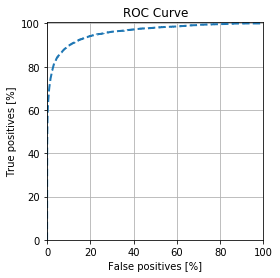

In [ ]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fp, tp, thr = plot_roc("Test Set", labels, predictions, color=colors[0], linestyle='--')

In [ ]:
thr = 0.9
# pos_pred = [ x.replace('.jpg','').split('-')[2:]+[y,z,x.split('-')[1]] \
#             for x,y,z in zip(test_generator.filenames,labels,predictions) if y > thr]

pos_pred = predictions_df[predictions_df['pred']>=thr][['x','y','label','slide_name']].values


tumor_094


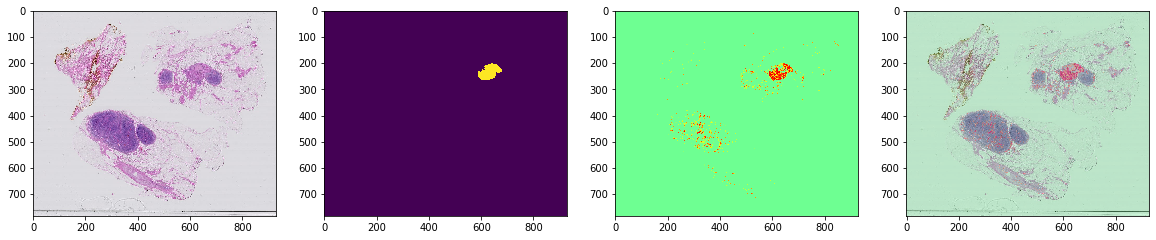

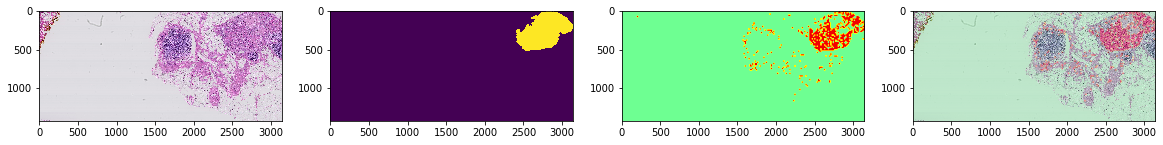

tumor_019


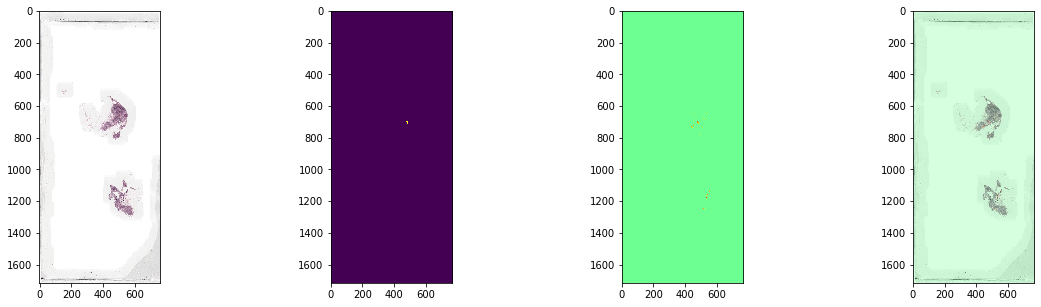

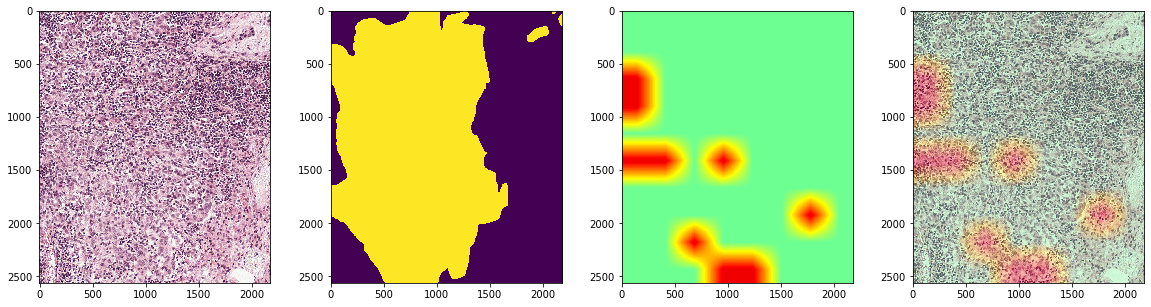

tumor_016


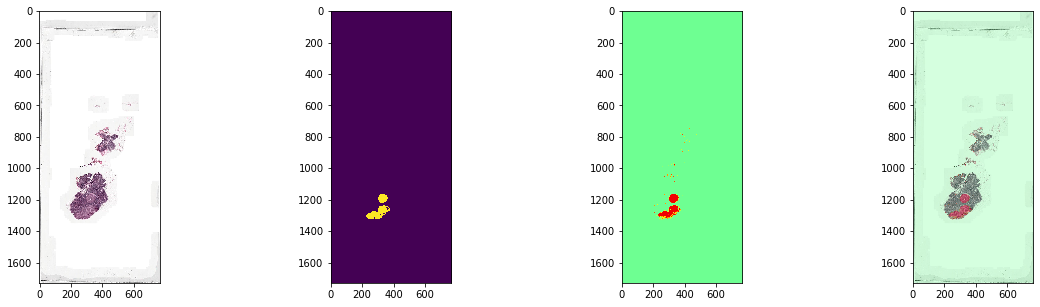

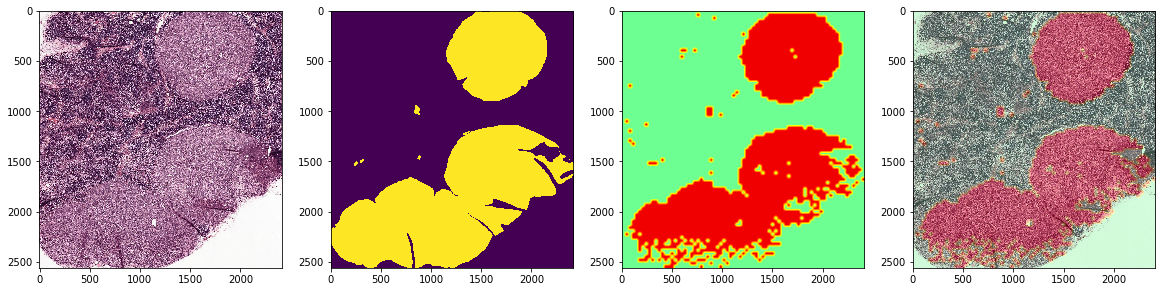

tumor_031


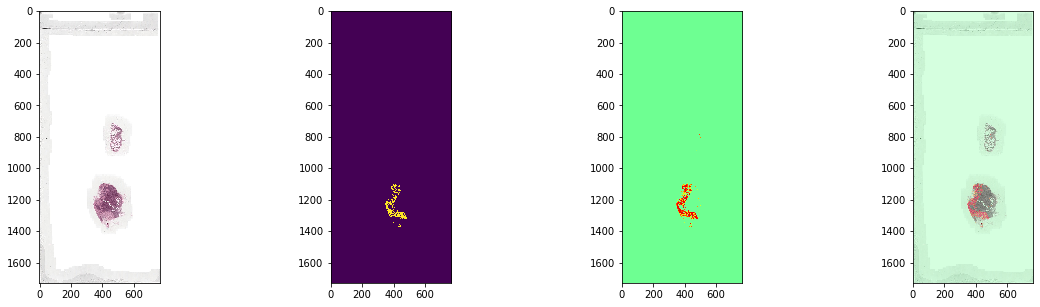

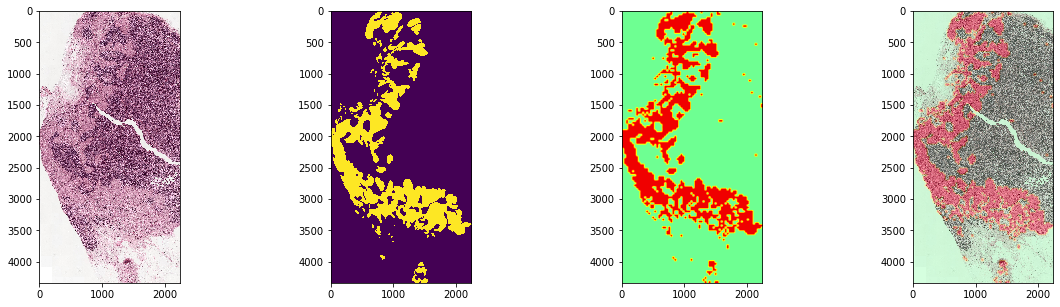

In [ ]:
for slide_name in test_slides:
  print(slide_name)
  slide_path = [s for s in slide_files if slide_name in s][0]
  mask_path = [m for m in mask_files if slide_name in m][0]
  slide = open_slide(slide_path)
  mask = open_slide(mask_path)
  w,h =slide.level_dimensions[7]
  img = read_slide(slide,level=7,x=0,y=0,width=w,height=h)
  msk = read_mask(mask,level=7,x=0,y=0,width=w,height=h)
  
  heatmap = np.asarray(Image.new('RGB', (w//2,h//2), color=(0, 0, 255))).copy()  
  coords = [(int(x)//256, int(y)//256) for x, y, l, s in pos_pred if s == slide_name]
  for x,y in coords:
    heatmap[y,x] = [255,0,0]
  heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
  heatmap = cv.applyColorMap(heatmap, cv.COLORMAP_JET)
  superimposed_img = (heatmap * 0.4 + img)
  superimposed_img /= superimposed_img.max()
  fix,axs = plt.subplots(nrows=1,ncols=4, figsize=(20,5))
  axs[0].imshow(img)
  axs[1].imshow(msk)
  axs[2].imshow(heatmap)
  axs[3].imshow(superimposed_img)
  plt.show()
  fix,axs = plt.subplots(nrows=1,ncols=4, figsize=(20,5))
  ymin,xmin = np.argwhere(msk==1).min(axis=0)
  ymax,xmax = np.argwhere(msk==1).max(axis=0)
  w = xmax-xmin
  h = ymax-ymin
  heatmapreg = np.asarray(Image.new('RGB', (w//2,h//2), color=(0, 0, 255))).copy()
  for x,y in coords:
    if (y*2>=ymin) &  (y*2-ymin < h) & (x*2>=xmin) & (x*2-xmin < w):
      try:
        heatmapreg[(y-ymin//2),(x-xmin//2)] = [255,0,0]
      except: pass
  for lv in range(8):
    level = lv
    if w*h*2**(7-lv)*2**(7-lv) >1e7:continue
    else: 
      level = lv
      break
  w *= 2**(7-level)
  h *= 2**(7-level)
  imgreg = read_slide(slide,level,x=xmin*2**7,y=ymin*2**7,width=w,height=h)
  mskreg = read_mask(mask,level,x=xmin*2**7,y=ymin*2**7,width=w,height=h)
  heatmapreg = cv.resize(heatmapreg, (imgreg.shape[1], imgreg.shape[0]))
  heatmapreg = cv.applyColorMap(heatmapreg, cv.COLORMAP_JET)
  heatmapreg = cv.applyColorMap(heatmapreg, cv.COLORMAP_JET)
  superimposed_reg = (heatmapreg * 0.4 + imgreg)
  superimposed_reg /= superimposed_reg.max()
  axs[0].imshow(imgreg)
  axs[1].imshow(mskreg)
  axs[2].imshow(heatmapreg)
  axs[3].imshow(superimposed_reg)
  plt.show()  
